# Japan specific COVID-19 Analysis for newbie <br>
Following dataset is used for this COVID-19 research   
[Kaggle COVID-19 Complete Dataset (Updated every 24hrs)](https://www.kaggle.com/imdevskp/corona-virus-report/data)



前日比率や差分のカラムを追加し、以下の情報を表示します
* データセットの概要
* データ期間・国数
* 世界の累積罹患者数、現在の罹患者数、累計死者数
* データセットの最新の情報

データの読み込み、国ごとのグループ化、地域と州のデータが存在する国をリストアップ

In [ ]:
import numpy as np
import pandas as pd
import warnings

# 警告表示の制御
warnings.simplefilter('ignore', FutureWarning)
# dataframeの全ての列を表示するように設定
pd.set_option('display.max_rows', None)
# ファイル読み込み
corona_df = pd.read_csv('../input/corona-virus-report/covid_19_clean_complete.csv')
# 日付のフォーマットを統一
corona_df["Date"] = list(map(lambda x: pd.datetime.strptime(x, '%m/%d/%y'),corona_df["Date"]))
# カラム名の変更
corona_df["Country"] = corona_df["Country/Region"]
# 最新の日付の取得
latest_date = corona_df["Date"].max().strftime("%Y/%m/%d")

# 国と日付ごとにグループ化
grouped_corona_df = corona_df.groupby(["Date", "Country"], as_index=False)
# 地域と州の数を国と日付毎に数えます
prov_counted_df = grouped_corona_df["Province/State"].count()
# 地域と州の数が2つ以上の国のリストを作成します
countries_with_prov = prov_counted_df[prov_counted_df["Province/State"]>1]["Country"].unique()
# 地域と州の数が2つ以上の国を表示します
display(countries_with_prov)

地域と州の数が2つ以上の国の情報を表示します（最新の日付のみ）  
世界の様々な場所に領土のある国もあり、同一国内でも緯度・経度が大きく離れている（例：フランスのNaN=本土とNew Caledonia）ことが分かります

In [ ]:
# 最新の日付で、地域と州の数が2つ以上の国の情報のみをみてみます
corona_prov_df = corona_df[(corona_df["Date"] == latest_date) & (corona_df["Country"].isin(countries_with_prov))]
# 内容を表示します
display(corona_prov_df.head(25))

地図上に表示するためには緯度・経度が必要となります  
国ごとに**最も感染者数の多い場所**の緯度・経度を抽出しておきます

In [ ]:
# 全ての国ごとに累計罹患者数が最大の行を取り出し、首都の緯度と経度を見つけます
capital_df = corona_df.loc[corona_df[corona_df["Date"] == latest_date].groupby(["Country"], as_index=False)["Confirmed"].idxmax(),:][["Country", "Lat", "Long"]]

# 内容を表示します
display(capital_df.head(25))

「累計罹患者数」「死者数」「回復者数」は合計し、「緯度」「経度」は直前に作成したcapital_dfで置き換える

In [ ]:
# グループ化したもののうち「累計罹患者数」「死者数」「回復者数」は合計を取り新たなcorona_dfとして置き換え
corona_df = grouped_corona_df[["Confirmed", "Deaths", "Recovered"]].sum()

# 「緯度」「経度」については先ほど作成したcapital_dfから国ごとに追加
corona_df = pd.merge(corona_df, capital_df, on="Country", how="left")

# データのある国名をリストで取得
countries = corona_df["Country"].unique()

# データにある国の数
num_countries = len(countries)

# 日付、累計罹患者数、国と地域でソートします
corona_df = corona_df.sort_values(by=["Date", "Confirmed", "Country"])

# 内容の表示
display(corona_df[["Country", "Confirmed", "Deaths", "Recovered", "Lat", "Long"]].tail(25)[::-1].style.background_gradient(cmap='Reds'))

データに「現在の罹患者数」「新規罹患者数」「新規死者数」「罹患者増減数」「致死率」「現在の罹患数に対する新規罹患者数比率」などのカラムを追加します

In [ ]:
# 現在の罹患者数カラムを追加
corona_df["Infected"] = corona_df["Confirmed"] - corona_df["Recovered"] - corona_df["Deaths"]

# データの情報を表示（国の数とデータの期間）
display("Number of COVID19 confirmed/deaths/recovered in total of " + str(num_countries) + " countries through " +
        corona_df["Date"].min().strftime("%Y/%m/%d") + " to " + latest_date)

# データの情報を表示（罹患者数、新規罹患者数、死亡者数、致死率）
display("Cumulated infected number = " + "{:,}".format(corona_df["Confirmed"].sum()) +  ", Current infected number = " + "{:,}".format(corona_df["Infected"].sum()) +
        ", total deaths = " + "{:,}".format(corona_df["Deaths"].sum()))

# 前日比と差分を追加
corona_df = corona_df.sort_values(by=["Country", "Date"])
corona_df["New_Confirmed"] = corona_df.groupby(["Country"])["Confirmed"].diff().fillna(0)
corona_df["New_Deaths"] = corona_df.groupby(["Country"])["Deaths"].diff().fillna(0)
corona_df["Fatality_Rate"] = corona_df["Deaths"]*100/corona_df["Confirmed"]
pd.set_option("display.max_rows", len(countries))

# 日付、罹患者数、国と地域でソートします
corona_df = corona_df.sort_values(by=["Date", "Confirmed", "Country"])

# 罹患者数が多い順に上位50ヵ国の最新の情報を表示します
display(corona_df[["Country", "Confirmed", "Infected", "New_Confirmed", "New_Deaths", "Fatality_Rate"]].tail(50)[::-1].style.background_gradient(cmap='Reds'))
countries50 = corona_df.tail(50)[::-1]["Country"].values

死者数を地図上に表示してみます
上位5ヵ国（アメリカ、イタリア、スペイン、フランス、イギリス）が大半を占めていることが分かります

In [ ]:
import folium
map_object = folium.Map(location=[0, 10], min_zoom=2, max_zoom=10, zoom_start=2)

for_map = corona_df.tail(num_countries)
for_map = for_map.dropna(subset=["Deaths"]).reset_index(drop=True)

for i in range(0, len(for_map)):
    folium.Circle(location=[for_map.iloc[i]["Lat"], for_map.iloc[i]["Long"]], color='crimson', fill=True,
        tooltip =   '<li><bold>Country : '+str(for_map.iloc[i]["Country"])+
                    '<li><bold>Deaths : '+str(for_map.iloc[i]["Deaths"]),
        radius=int(for_map.iloc[i]["Deaths"])*20).add_to(map_object)
map_object

日本の罹患状況を表示します（人数は対数表示）

In [ ]:
# 不要な要素（緯度・経度）を削除
corona_df = corona_df.drop(columns=["Lat", "Long"])

country_df = corona_df[corona_df["Country"]=="Japan"].copy()
display(country_df.tail(30))

グラフに表示します

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
%matplotlib inline

fig_rows = math.ceil((len(corona_df.columns) - 2)/2)
fig = plt.figure(figsize=(40,60),facecolor='white')
plt.rcParams["font.size"] = 18

for i, col in enumerate(corona_df.columns):
  temp_df = country_df.copy()
  if col == "Date" or col =="Country":
    continue
  plt.subplot(fig_rows,2,i-1)
  plt.title(col)
  plt.plot(temp_df["Date"], temp_df[col], label="Japan")
  plt.yscale("linear")
  if col == "Fatality_Rate":
    plt.ylim([0, 5])
  plt.grid(True)
plt.legend(loc="upper center", bbox_to_anchor=(0.5,-0.05),ncol=6)
plt.show()

対数グラフに表示します

In [ ]:
fig_rows = math.ceil((len(corona_df.columns) - 2)/2)
fig = plt.figure(figsize=(40,60),facecolor='white')
plt.rcParams["font.size"] = 18

for i, col in enumerate(corona_df.columns):
  temp_df = country_df.copy()
  if col == "Date" or col =="Country":
    continue
  plt.subplot(fig_rows,2,i-1)
  plt.title(col)
  plt.plot(temp_df["Date"], temp_df[col], label="Japan")
  plt.yscale("log")
  if col == "Fatality_Rate":
    plt.yscale("linear")
    plt.ylim([0, 5])
  plt.grid(True)
plt.legend(loc="upper center", bbox_to_anchor=(0.5,-0.05),ncol=6)
plt.show()

新規罹患者数や死者数、増減などは所々ゼロやマイナスがあり、なめらかではないためスムージング処理を施したグラフも追加します  
生データ、3日間の移動平均、5日間の移動平均を重ねて表示しています  
移動平均は遅効性があるため、平均日数の中央になるよう日付をシフトしています  

In [ ]:
fig_rows = math.ceil((len(corona_df.columns) - 2)/2)
fig = plt.figure(figsize=(40,60),facecolor='white')
plt.rcParams["font.size"] = 18
for i, col in enumerate(corona_df.columns):
  temp_df = country_df.copy()
  if col == "Date" or col =="Country":
    continue
  plt.subplot(fig_rows,2,i-1)
  plt.title(col)
  plt.plot(temp_df["Date"], temp_df[col], label="Raw")
  plt.plot(temp_df["Date"], temp_df[col].rolling(3).mean().shift(-1), label="MA3")
  plt.plot(temp_df["Date"], temp_df[col].rolling(5).mean().shift(-3), label="MA5")
  plt.yscale("log")
  if col == "Fatality_Rate":
    plt.yscale("linear")
    plt.ylim([0, 5])
  plt.grid(True)
plt.legend(loc="upper center", bbox_to_anchor=(0.5,-0.05),ncol=6)
plt.show()

****世界の状況を表示します（人数は対数表示）****  
ここからは5日移動平均線の3日シフトのみを表示します。

In [ ]:
fig_rows = math.ceil((len(corona_df.columns) - 2)/2)
fig = plt.figure(figsize=(40,60),facecolor='white')
plt.rcParams["font.size"] = 18
for i, col in enumerate(corona_df.columns):
  if col == "Date" or col =="Country":
    continue
  plt.subplot(fig_rows,2,i-1)
  plt.title(col + "_MA5-3")
  for country in corona_df["Country"].unique():
    country_df = corona_df[corona_df["Country"]==country].copy()
    plt.plot(country_df["Date"], country_df[col].rolling(5).mean().shift(-3), label=country)
    plt.yscale("log")
  if col == "Fatality_Rate":
    plt.yscale("linear")
    plt.ylim([0, 20])
  plt.grid(True)
plt.legend(loc="upper center", bbox_to_anchor=(0.5,-0.05),ncol=6)
plt.show()

In [ ]:
day_one = corona_df[(corona_df["Confirmed"]>1) & (corona_df["Country"].isin(countries50))].groupby(["Country"])["Date"].min()
display(day_one.sort_values().head(20))

国別に累計罹患者数が1人を超えた日を日本を基準に日付をシフト

In [ ]:
day_one_shift = day_one - day_one["Japan"]
display(day_one_shift.sort_values().head(20))

国別に累計罹患者数が1人を超えた日をDay1とし、日本に合わせて日付をシフトさせます

In [ ]:
from datetime import timedelta

fig_rows = math.ceil((len(corona_df.columns) - 2)/2)
fig = plt.figure(figsize=(40,60),facecolor='white')
plt.rcParams["font.size"] = 18

for i, col in enumerate(corona_df.columns):
  if col == "Date" or col =="Country":
    continue
  plt.subplot(fig_rows,2,i-1)
  plt.title(col + "_MA5-3")
  for country in countries50:
    country_df = corona_df[corona_df["Country"]==country].copy()
    if country in day_one_shift.index:
      plt.plot(country_df["Date"] - timedelta(days=day_one_shift[country].days), country_df[col].rolling(5).mean().shift(-3), label=country)    
    plt.yscale("log")
  if col == "Fatality_Rate":
    plt.yscale("linear")
    plt.ylim([0, 20])
  plt.grid(True)
plt.legend(loc="upper center", bbox_to_anchor=(0.5,-0.05),ncol=6)
plt.show()

同様に死者数が2人を超えた日をDay1として日付をずらした場合
こちらの方が見た目フィットしているようです

In [ ]:
day_one = corona_df[(corona_df["Deaths"]>2) & (corona_df["Country"].isin(countries50))].groupby(["Country"])["Date"].min()
day_one_shift = day_one - day_one["Japan"]
fig_rows = math.ceil((len(corona_df.columns) - 2)/2)
fig = plt.figure(figsize=(40,60),facecolor='white')
plt.rcParams["font.size"] = 18

for i, col in enumerate(corona_df.columns):
  if col == "Date" or col =="Country":
    continue
  plt.subplot(fig_rows,2,i-1)
  plt.title(col + "_MA5-3")
  for country in countries50:
    country_df = corona_df[corona_df["Country"]==country].copy()
    if country in day_one_shift.index:
      plt.plot(country_df["Date"] - timedelta(days=day_one_shift[country].days), country_df[col].rolling(5).mean().shift(-3), label=country)  
    plt.yscale("log")
  if col == "Fatality_Rate":
    plt.yscale("linear")
    plt.ylim([0, 20])
  plt.grid(True)
plt.legend(loc="upper center", bbox_to_anchor=(0.5,-0.05),ncol=6)
plt.show()

# SIRモデル
4月7日に政府が緊急事態宣言を発出
その中で人との接触を8割削減することを目標とし、厚労省新型コロナウイルス対策本部クラスター対策班メンバーで、感染症に詳しい北海道大学の西浦教授の提案を採用した言われている
西浦教授の提案根拠は感染症流行の数理モデルの一つであるSIRモデルに基づいている

SIRモデルにおいて、全人口は3つへ分割される

1. 罹患しうる人（Susceptible）
2. 罹患者（Infected）
3. 罹患しない人（Removed：回復者と死亡者）

以下にSIRモデルの微分方程式とその解説を記載  

①罹患しうる人の数$S(t)$は、ある日$t$に新規罹患者数だけ減少する（単調減少）  
*※SIRモデルでは再罹患しないものと考える*   
*※$\beta$は「一人の罹患者が1日に接触する平均人数」×「感染率」、$N$は総人口*  
*※罹患者との接触者の内、罹患しうる人の割合は、「罹患しうる人の数」÷「総人口」と考える*
$$\frac {dS(t)}{dt} = -\beta I(t)\frac {S(t)}{N}$$  
  
②罹患しない人の数$R(t)$は、ある日$t$に罹患者数$I(t)$の一定割合$\gamma$だけ回復または死亡しその分増加する（単調増加）    
*※$\gamma$は回復・死亡率*  
$$\frac {dR(t)}{dt}=\gamma I(t)$$  
  
③罹患者数$I(t)$は、ある日$t$に新規罹患者数だけ増加し、回復者数だけ減少する
$$\frac {dI(t)}{dt} = \beta I(t)\frac {S(t)}{N}-\gamma I(t)$$  

基本再生産数$R_0$は、何もしなかったときに罹患者一人が回復するまでに何人に感染させるかを意味する  

**例えば、**  
・一人の罹患者が1日に接触する平均人数を20人  
・感染率を1.25%  
・罹患者が感染力を持つ平均日数$1/\gamma$を10日  
と置き、  
罹患者数は総人口に対してまだ十分少ないので、接触者は全て罹患しうる人と考えれば

$$R_0 = \beta / \gamma = 20 * 0.0125 * 10 = 2.5$$

現実的には、罹患者の平均接触人数や感染率を知る事は困難である  
そこで、入院日数を感染力を持つ平均日数として代用したり、罹患者数に対する新規罹患者数の割合を$R_0$として代用し、$\beta$数値を推定することが多い  

また、感染者の隔離措置、社会的距離の確保、マスクの着用、ワクチンの接種等により、この$R_0$は時間と共に変化する  
その時点での再生産数を実効再生産数$R_0(t)$とすれば、感染拡大を防ぐためには  

$$R_0(t) < 1$$

を維持する必要がある



各国の人口データから日本の人口を取得

In [ ]:
df_pop = pd.read_csv('../input/population-by-country-2020/population_by_country_2020.csv')
N = df_pop[df_pop["Country (or dependency)"] == "Japan"]["Population (2020)"].values[0]
display(N)

では、さっそくSIRモデルを実装してみる  
[Reference:Infectious Disease Modelling: Fit Your Model to Coronavirus Data by Henri Froese](https://towardsdatascience.com/infectious-disease-modelling-fit-your-model-to-coronavirus-data-2568e672dbc7)

先ほど取得した日本の人口を使い、初期$R_0$を5.0、収束値を1.0として罹患者数、死亡者数の推移を予測します

In [ ]:
from scipy.integrate import odeint
from matplotlib.ticker import ScalarFormatter

def logistic_R_0(t, R_0_start, k, x0, R_0_end):
    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

def func_SIR(initial, t, N, R_0_start, k, x0, R_0_end, gamma):
    S, I, R = initial
    beta = logistic_R_0(t, R_0_start, k, x0, R_0_end) * gamma
    dSdt = -beta * S * I/ N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

full_days = 250
D = 13.5
gamma = 1.0 / D
t = np.linspace(0, full_days-1, full_days)
initial = N-1.0, 1.0, 0.0

def Model(days, N, R_0_start, k, x0, R_0_end):
    t = np.linspace(0, days-1, days)
    ret = odeint(func_SIR, initial, t, args=(N, R_0_start, k, x0, R_0_end, gamma))
    S, I, R = ret.T
    R_0_over_time = [logistic_R_0(i, R_0_start, k, x0, R_0_end) for i in range(len(t))]
    return t, S, I, R, R_0_over_time

outbreak_shift = 30
fatal_rate = corona_df[corona_df["Country"] == "Japan"]["Fatality_Rate"].values[[-1]]/100
print(fatal_rate)

# plt.gcf().subplots_adjust(bottom=0.15)

def plotter(t, S, I, R, R_0, x_ticks=None):
    f, ax = plt.subplots(1,1,figsize=(20,4))
    if x_ticks is None:
        ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(t, R*fatal_rate, 'b', alpha=0.7, linewidth=2, label='Fatalities')
    else:
        ax.plot(x_ticks, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(x_ticks, R*fatal_rate, 'g', alpha=0.7, linewidth=2, label='Fatalities')

        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        f.autofmt_xdate()

    ax.title.set_text('SIR-Model')

    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    plt.show();
    
    f = plt.figure(figsize=(20,4))

    ax1 = f.add_subplot(131)
    if x_ticks is None:
        ax1.plot(t, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
    else:
        ax1.plot(x_ticks, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
        ax1.xaxis.set_major_locator(mdates.MonthLocator())
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        f.autofmt_xdate()

 
    ax1.title.set_text('R_0 over time')
    ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax1.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    plt.show();
    
first_date = np.datetime64(corona_df["Date"].min()) - np.timedelta64(outbreak_shift,'D')
x_ticks = pd.date_range(start=first_date, periods=full_days, freq="D")
    
plotter(*Model(full_days, N, 5.0, 1.0, 60, 1.0), x_ticks=x_ticks)

display(day_one["Japan"])
# def end99(t, day1, I, R):

# display(t[I<R.max()*0.01])
# display("Final R = " + "{:,}".format(int(R.max())))

In [ ]:
# カーブフィッティングライブラリのインストール
!pip install lmfit

In [ ]:
import lmfit

data = corona_df[corona_df["Country"] == "Japan"]["Infected"].values
days = outbreak_shift + len(data)
if outbreak_shift >= 0:
    y_data = np.concatenate((np.zeros(outbreak_shift), data))
else:
    y_data = y_data[-outbreak_shift:]

x_data = np.linspace(0, days - 1, days, dtype=int)  # x_data is just [0, 1, ..., max_days] array

def fitter(x, R_0_start, k, x0, R_0_end):
    ret = Model(days, N, R_0_start, k, x0, R_0_end)
    return ret[3][x]

mod = lmfit.Model(fitter)

params_init_min_max = {"R_0_start": (5.0, 2.0, 5.8), "k": (2.5, 0.01, 5.0), "x0": (90, 0, 120), "R_0_end": (0.9, 0.3, 3.5)}
# form: {parameter: (initial guess, minimum value, max value)}

for kwarg, (init, mini, maxi) in params_init_min_max.items():
    mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

params = mod.make_params()
fit_method = "leastsq"

result = mod.fit(y_data, params, method="least_squares", x=x_data)
result.plot_fit(datafmt="-")

plotter(*Model(full_days, N, **result.best_values), x_ticks=x_ticks)

result.best_values

ロックダウンによる$R_0$の変化をシグモイド関数で近似していることもありますが、4月の第一週以降急激に$R_0$が低下し、0.3まで落ちています

カーブフィッティング

5月1日発表の政府見解（新型コロナウイルス感染症対策の状況分析・提言、厚生労働省サイト）  
[https://www.mhlw.go.jp/content/10900000/000627254.pdf](https://www.mhlw.go.jp/content/10900000/000627254.pdf)  

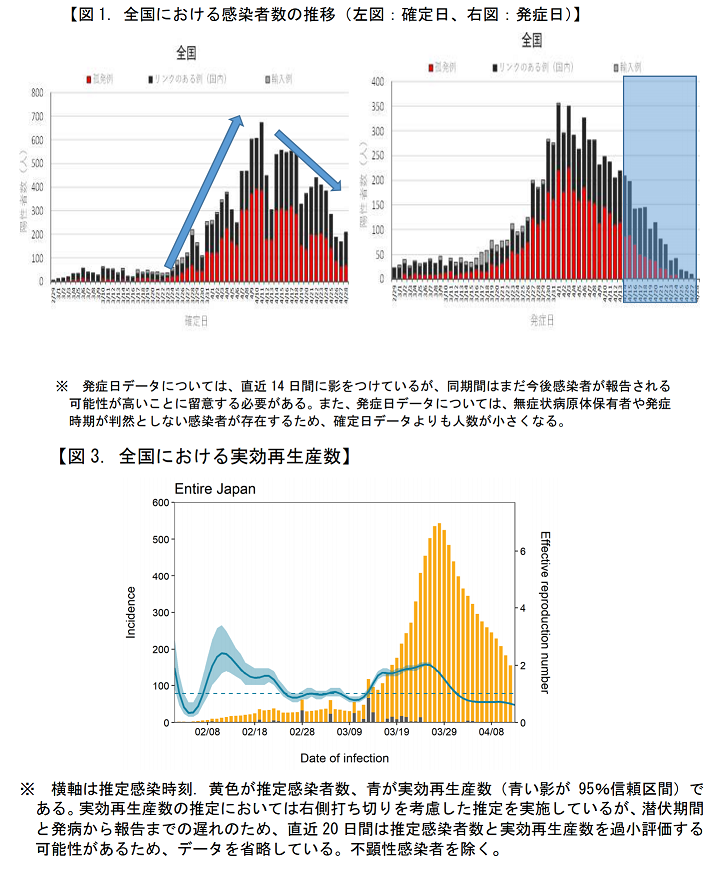

1日に政府の専門家会議がまとめた提言は新型コロナウイルスの新たな感染者は減っているとしつつも、減り具合が目指したほどではなく、医療体制も逼迫（ひっぱく）していると指摘した。

感染が拡大しているかをみる重要な指標の一つが「実効再生産数」だ。感染者1人が何人に感染させるかを示す値で、1より大きければ流行は拡大し、小さいと収束していく。全国で2・0（3月25日時点）、東京で2・6（3月14日時点）だったが、4月10日時点では全国で0・7、東京で0・5まで下がった。

　厚生労働省クラスター対策班に参加する西浦博・北海道大教授（理論疫学）は、1を下回ったのは全国も東京も緊急事態宣言が出る前の4月1日ごろだったと説明。そのうえで、「1を割るだけでは感染者数を十分に減らすことには足らない。全国的にみると、8割の接触機会の削減で求めていた水準には達していない」と指摘。目標とする0・5以下になることを確認していく必要があるとした。

実効再生産数$R(t)$はどの様に算出されているのでしょうか。  
厚労省の資料には説明がないので推測します。  
図１を見ると発症日と確定日の二つのグラフがあります。
ピークに着目すると、確定日のピークは4月11日、発症日のピークは4月1日となります。  
一方で図3から$R(t)$が1以下となる（=感染縮小に転する）直近の日を見てみると4月1日ですので、この10日間を発症からPCR検査結果が出るまでの時間遅延として考え、発症日ベースで$R(t)$を算出しているものと推測できます。  

$R(t)$の算出方法としては以下の論文に記載があります。  
[https://www.medrxiv.org/content/10.1101/2020.01.27.20018952v1.full.pdf](https://www.medrxiv.org/content/10.1101/2020.01.27.20018952v1.full.pdf)

$R(t)=K(t)^2・L・D+ K(t)(L+D) + 1$

$L$=平均潜伏期間,
$D$=平均感染期間,
$K(t)$=対数成長速度,

COVID-19の平均潜伏期間は5~6日とされている（WHO 5~6日、中国 6.2、福井 4.76）ので、5.5日として計算。
平均感染期間を入院期間と考えると11~16日との報告があるので、13.5日として計算
対数成長速度$K(t)$は、以下のように算出し、日本の感染者数推移からR(t)の式を割り出します。


$R(t)$のみ3日平均でスムージング

In [ ]:
#7日分の傾きから罹患者数の対数成長速度を算出、

confirm_delay = 10
diff_days =7
sma = 3
adjust = math.floor(sma/2)
# smaスムージング有り
logged_inf_delayed_sma = corona_df['Infected'].shift(-confirm_delay).rolling(sma).mean().shift(-adjust).apply(np.log10).copy()
# smaスムージング無し
# logged_inf_delayed = corona_df['Infected'].shift(-confirm_delay).apply(np.log10).copy()
                    
corona_df["K_t"] = (logged_inf_delayed_sma-logged_inf_delayed_sma.shift(diff_days))/diff_days

#　$L=5.5$、$D=13.5$として$R(t)$を算出
L = 5.5
D = 13.5
corona_df["R_t"] = corona_df["K_t"].apply(lambda x: np.power(x, 2)*L*D + x*(L+D) + 1)

fig = plt.figure(figsize=(40,30),facecolor='white')
plt.rcParams["font.size"] = 18

country_df = corona_df[corona_df["Country"]=="Japan"].copy()

country_df["R_t"] = country_df["R_t"].replace([np.inf, -np.inf], np.nan)
country_df = country_df.dropna(subset=["R_t"])
display(country_df[["Date", "R_t"]].tail(70).style.background_gradient(cmap='Reds'))

plt.subplot(2,2,1)
plt.title("K(t)")
plt.plot(country_df["Date"], country_df["K_t"])
plt.ylim([0,0.2])
plt.grid(True)
plt.subplot(2,2,2)
plt.title("R(t)")
plt.plot(country_df["Date"], country_df["R_t"])
plt.ylim([0,6])
plt.grid(True)
plt.show()

In [ ]:
country_df = corona_df[corona_df["Country"]=="Japan"].copy()

fig = plt.figure(figsize=(17,10),facecolor='white')
plt.rcParams["font.size"] = 18
plt.title("R(t)")
plt.ylim([0,6])
plt.plot(country_df["Date"], country_df["R_t"].rolling(3).mean().shift(-1))
plt.grid(True)
plt.show()

カーブフィッティングから$R_0$を算出した時と同様に、1を下回ることは一度もありません。

以下は発症日基準ではなく感染確定日基準の場合  
3日移動平均でスムージング

In [ ]:
#7日分の傾きから罹患者数の対数成長速度を算出、

diff_days =7
sma = 3
adjust = math.floor(sma/2)
# smaスムージング有り
logged_new_conf_sma3 = corona_df['Infected'].rolling(sma).mean().shift(-adjust).apply(np.log10).copy()
                    
corona_df["K_t"] = (logged_new_conf_sma3-logged_new_conf_sma3.shift(diff_days))/diff_days

#　$L=5.5$、$D=13.5$として$R(t)$を算出
L = 5.5
D = 13.5
corona_df["R_t"] = corona_df["K_t"].apply(lambda x: np.power(x, 2)*L*D + x*(L+D) + 1)

fig = plt.figure(figsize=(17,10),facecolor='white')
plt.rcParams["font.size"] = 18

country_df = corona_df[corona_df["Country"]=="Japan"].copy()

country_df["R_t"] = country_df["R_t"].replace([np.inf, -np.inf], np.nan)
country_df = country_df.dropna(subset=["R_t"])
display(country_df[["Date", "R_t"]].style.background_gradient(cmap='Reds'))

plt.title("R(t)")
plt.plot(country_df["Date"], country_df["R_t"])
plt.ylim([0,6])
plt.grid(True)
plt.show()

$R(t)$ のみ5日平均でスムージング

In [ ]:
country_df = corona_df[corona_df["Country"]=="Japan"].copy()

fig = plt.figure(figsize=(17,10),facecolor='white')
plt.rcParams["font.size"] = 18
plt.title("R(t)")
plt.ylim([0,6])
# plt.plot(country_df["Date"], country_df["R_t"])
plt.plot(country_df["Date"], country_df["R_t"].rolling(5).mean().shift(-3))
plt.grid(True)
plt.show()

# 考察　 
   [考察1]  
   SIRモデルは1度感染した人は2度感染しないという前提だが、
   COVID19では2度感染する事例多数ある、抗体が作られない確率も考慮するモデルが必要  
   [考察2]  
   非常事態宣言後の傾向、都心の人手は目標の70%減を超えている  
   大阪 梅田周辺: 86.9％、東京 新宿周辺: 79.9％、福岡 天神周辺: 77.7％、横浜駅周辺: 77％  
   大宮駅周辺: 72.8％、兵庫県の三ノ宮駅周辺: 71.7％、千葉駅周辺: 71.5％  
   *NTTドコモの携帯電話基地局の情報から推計
   
[東京都のページより](https://corona.go.jp/toppage/pdf/area-transition/20200503_agoop.pdf)

   [考察3]  
   感染者のうち一定割合が重症化すると考え、重症患者が必要とするICUの数と死亡率も含めて検討する余地あり  
   
   [考察4]  
   感染者のうち隔離されている人、自宅待機している人、自由に動いている人で分類することも検討の余地あり